In [35]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from timeit import default_timer as timer

In [2]:
# for parallelization if necessary
#from dask import compute, delayed
#from dask.distributed import Client, LocalCluster 
#cl = LocalCluster(n_workers=4)
#client = Client(cl)
#cl

# note: if this throws an error, close jupyter, run "ulimit -n 4096" in terminal, then restart jupyter

In [2]:
# define data location
# location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'

In [3]:
# read data from pickle
start = timer()

# what data granularity?
granularity = "daily"

# if we're clustering first, we need to load in sufficient_ data to ensure data equivalency across IDs
if granularity == "daily":
    readdata = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
    weather = pd.read_pickle(location+'daily_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_daily_ids.pkl.zip')
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip')
    weather = pd.read_pickle(location+'hourly_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_hourly_ids.pkl.zip')
else:
    print("Granularity selected was not 'daily' or 'hourly'")

end = timer()
print((end - start)/60) # Time in minutes (~7 min for hourly data)

0.015089551066671448


In [4]:
readdata.head()

,ID,Dt,Use,DACCOUNTID,DCUSTOMERID,DMETERNO,TARIFF,FUELTYPE,REVENUCODE,Weekday,Holiday
634064,"(92567555369200, 732213258492)",2017-10-12,1.0,92567555369200,29381522572072,732213258492,GH0,GAS,1.0,1,0
997476,"(153032728174616, 796095404148)",2017-10-12,0.0,153032728174616,518685586224,796095404148,GHC,GAS,3.0,1,0
996753,"(152994924937308, 724945750304)",2017-10-12,5.7,152994924937308,3403523328224,724945750304,UHC,GAS,3.0,1,0
1480056,"(238775655555924, 4967981836972)",2017-10-12,0.0,238775655555924,3153998418632,4967981836972,UHC,GAS,3.0,1,0
1028268,"(163414110819212, 606793638912)",2017-10-12,1.0,163414110819212,1704916575156,606793638912,UGH,GAS,1.0,1,0


## Behavioral Analysis ##

In [6]:
# Cumulative Distribution Function Plot
def cdf(x):
    """cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

#### are there distinct groups based on magnitude of use? ####

In [7]:
# aggregate to the daily level regardless of level of data read in
if granularity == 'daily':
    use = readdata[['ID','Use']].groupby('ID').mean().reset_index()
elif granularity == 'hourly':
    use = readdata[['ID','Dt','Use']]
    use['Dt'] = use['Dt'].dt.date
    use = use.groupby(['ID','Dt']).sum().reset_index()
    use = use.groupby('ID').mean().reset_index()
    
use.head()

,ID,Use
0,"(665128346596, 4464578359312)",0.431925
1,"(819252079392, 609154378812)",0.403602
2,"(819288717920, 4465122076620)",0.895714
3,"(819880484484, 4465122193056)",0.948820
4,"(1284453836940, 4464330738752)",0.739938


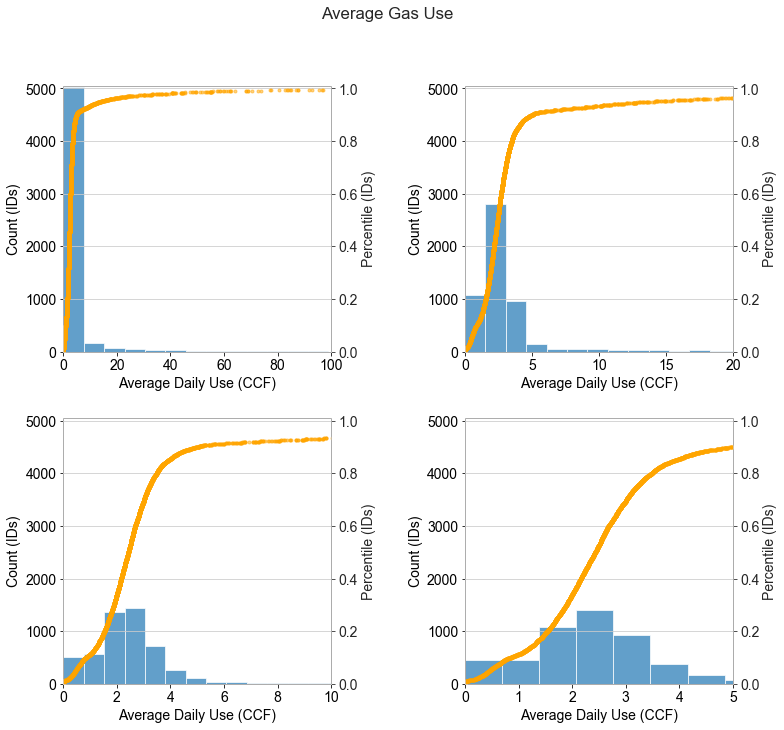

In [8]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,11))
sns.set_style('whitegrid')
fig.suptitle('Average Gas Use')
fig.subplots_adjust(hspace=0.25, wspace=0.5)

x, y = cdf(use['Use'])

# axs[0,0].hist(use['Use'], 100, alpha=.7)
# axs[0,0].set_xlim(0,1000)
# axs[0,0].set_ylim(0,5050)
# layer1 = axs[0,0].twinx()
# layer1.plot(x, y, '.', color="orange", alpha=.5)
# layer1.set_ylim(0,1.01)
# axs[0,0].set_xlabel("Average Daily Use (CCF)"); axs[0,0].set_ylabel("Count (IDs)"); layer1.set_ylabel("Percentile (IDs)"); 

axs[0,0].hist(use['Use'], 500, alpha=.7)
axs[0,0].set_xlim(0,100)
axs[0,0].set_ylim(0,5050)
layer2 = axs[0,0].twinx()
layer2.plot(x, y, '.', color="orange", alpha=.5)
layer2.set_ylim(0,1.01)
axs[0,0].set_xlabel("Average Daily Use (CCF)"); axs[0,0].set_ylabel("Count (IDs)"); layer2.set_ylabel("Percentile (IDs)"); 

# axs[0,2].hist(use['Use'], 1000, alpha=.7)
# axs[0,2].set_xlim(0,50); axs[0,2].xaxis.set_ticks(np.arange(0, 60, step=10))
# axs[0,2].set_ylim(0,5050)
# layer3 = axs[0,2].twinx()
# layer3.plot(x, y, '.', color="orange", alpha=.5)
# layer3.set_ylim(0,1.01)
# axs[0,2].set_xlabel("Average Daily Use (CCF)"); axs[0,2].set_ylabel("Count (IDs)"); layer3.set_ylabel("Percentile (IDs)"); 

# second row
axs[0,1].hist(use['Use'], 2500, alpha=.7)
axs[0,1].set_xlim(0,20)
axs[0,1].set_ylim(0,5050)
layer4 = axs[0,1].twinx()
layer4.plot(x, y, '.', color="orange", alpha=.5)
layer4.set_ylim(0,1.01)
axs[0,1].set_xlabel("Average Daily Use (CCF)"); axs[0,1].set_ylabel("Count (IDs)"); layer4.set_ylabel("Percentile (IDs)"); 

axs[1,0].hist(use['Use'], 5000, alpha=.7)
axs[1,0].set_xlim(0,10)
axs[1,0].set_ylim(0,5050)
layer5 = axs[1,0].twinx()
layer5.plot(x, y, '.', color="orange", alpha=.5)
layer5.set_ylim(0,1.01)
axs[1,0].set_xlabel("Average Daily Use (CCF)"); axs[1,0].set_ylabel("Count (IDs)"); layer5.set_ylabel("Percentile (IDs)"); 

axs[1,1].hist(use['Use'], 5500, alpha=.7)
axs[1,1].set_xlim(0,5); axs[1,1].xaxis.set_ticks(np.arange(0, 6, step=1))
axs[1,1].set_ylim(0,5050)
layer6 = axs[1,1].twinx()
layer6.plot(x, y, '.', color="orange", alpha=.5)
layer6.set_ylim(0,1.01)
axs[1,1].set_xlabel("Average Daily Use (CCF)"); axs[1,1].set_ylabel("Count (IDs)"); layer6.set_ylabel("Percentile (IDs)"); 

# save
fig.savefig(location+'Avg_gas_use.png')

In [9]:
# it looks like we have 4 groups: 
# * minimal users (avg use <= 1.5)
# * light users (avg use > 1.5 & <= 3.5)
# * moderate users (avg use > 3.5 & <= 10)
# * huge users (avg use > 10)
use['UseGroup'] = None
use.loc[ use.Use <= 1.5, 'UseGroup'] = 0
use.loc[ (use.Use > 1.5) & (use.Use <= 3.5), 'UseGroup'] = 1
use.loc[ (use.Use > 3.5) & (use.Use <= 10), 'UseGroup'] = 2
use.loc[ use.Use > 10, 'UseGroup'] = 3
use.head()

,ID,Use,UseGroup
0,"(665128346596, 4464578359312)",0.431925,0
1,"(819252079392, 609154378812)",0.403602,0
2,"(819288717920, 4465122076620)",0.895714,0
3,"(819880484484, 4465122193056)",0.948820,0
4,"(1284453836940, 4464330738752)",0.739938,0


#### Is there a difference in use between cold months and warm months (i.e., is there gas heat?) ####

In [10]:
# look at whether there's a difference in use between cold months and warm months (i.e., is there gas heat?)
readdata['coldmonths'] = pd.get_dummies((readdata['Dt'].dt.month <= 2) | (readdata['Dt'].dt.month >= 11))[True]
readdata['warmmonths'] = pd.get_dummies((readdata['Dt'].dt.month >= 6) & (readdata['Dt'].dt.month <= 9))[True]

cold = (readdata[readdata['coldmonths']==1][['ID','Use']]#### are there distinct groups based on magnitude of use? ####
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'colduse'}))
warm = (readdata[readdata['warmmonths']==1][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'warmuse'}))
total = (readdata[(readdata['coldmonths']==1) | (readdata['warmmonths']==1)][['ID','Use']]
         .groupby('ID').sum().reset_index()
         .rename(columns={'Use':'totaluse'}))

gasheat = cold.merge(warm, how='inner', on='ID').merge(total, how='inner', on='ID')
gasheat['pctcold'] = gasheat['colduse']/gasheat['totaluse']

del (cold,warm,total)
readdata = readdata.drop(columns=['coldmonths','warmmonths'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


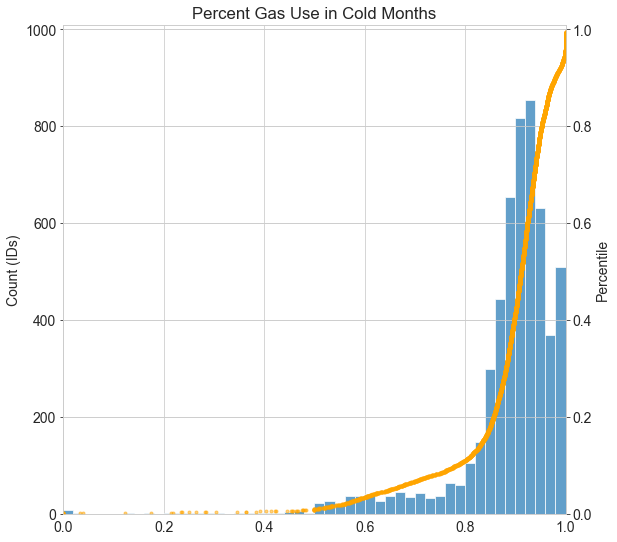

In [11]:
# plot 
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(figsize=(9,9))
sns.set_style('whitegrid')

x, y = cdf(gasheat['pctcold'])
ax.hist(gasheat['pctcold'], bins=50, alpha=.7)
ax.set_xlim(0,1)
ax.set_ylim(0,1010)
layer = ax.twinx()
layer.plot(x, y, '.', color="orange", alpha=.5)
layer.set_ylim(0,1.01)
plt.title('Percent Gas Use in Cold Months'); 
plt.xlabel('Pct Use in Cold Months'); ax.set_ylabel('Count (IDs)'); layer.set_ylabel('Percentile'); 

# save
f.savefig(location+'cold_gas_use.png')

In [12]:
# it looks like we have 3 groups: 
# * those using <59% gas in the winter, 
# * those using 59-80% gas in winter, 
# * those using >80% gas in winter
gasheat['ColdGroup'] = None
gasheat.loc[ gasheat.pctcold < .68, 'ColdGroup'] = 0
gasheat.loc[ (gasheat.pctcold >= .68) & (gasheat.pctcold < .8), 'ColdGroup'] = 1
gasheat.loc[ gasheat.pctcold >= .8, 'ColdGroup'] = 2
gasheat.head()

,ID,colduse,warmuse,totaluse,pctcold,ColdGroup
0,"(665128346596, 4464578359312)",68.40,33.06,101.46,0.674157,0
1,"(819252079392, 609154378812)",60.42,28.50,88.92,0.679487,0
2,"(819288717920, 4465122076620)",157.32,42.18,199.50,0.788571,1
3,"(819880484484, 4465122193056)",87.78,106.02,193.80,0.452941,0
4,"(1284453836940, 4464330738752)",87.78,67.26,155.04,0.566176,0


#### Is there a difference in use between weekdays and weekends/holidays? ####

In [13]:
# look at whether there's a difference in use between weekdays and weekends/holidays
weekday = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0)][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'wdayuse'}))
weekend = (readdata[(readdata['Weekday']==0) | (readdata['Holiday']==1)][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'wenduse'}))
total = (readdata[['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'totaluse'}))

dayuse = (weekday.merge(weekend, how='inner', on='ID').merge(total, how='inner', on='ID'))
dayuse['pctwday'] = dayuse['wdayuse'] / dayuse['totaluse']
dayuse['pctwend'] = dayuse['wenduse'] / dayuse['totaluse']

del (weekday,weekend,total)

In [14]:
# # plot 
plt.rcParams.update({'font.size': 14})

# f, ax = plt.subplots(figsize=(9,9))
# sns.set_style('whitegrid')

# x, y = cdf(dayuse['pctwday'])
# ax.hist(dayuse['pctwday'], bins=50, alpha=.7)
# ax.set_xlim(0,1)
# ax.set_ylim(0,2525)
# layer = ax.twinx()
# layer.plot(x, y, '.', color="orange", alpha=.5)
# layer.set_ylim(0,1.01)
# plt.title('Percent Gas Use on Weekdays'); 
# plt.xlabel('Pct Use on Weekdays'); ax.set_ylabel('Frequency'); layer.set_ylabel('Percentile'); 

# # save
# fig.savefig(location+'weekday_gas_use.png')

In [15]:
# fairly tight distribution with no clear breaks; split at median
# Note: expect this to be weighted toward weekdays (5/7=.714...)
dayuse['DayGroup'] = None
dayuse.loc[ dayuse.pctwend < dayuse['pctwday'].median(), 'DayGroup'] = 0
dayuse.loc[ dayuse.pctwend > dayuse['pctwday'].median(), 'DayGroup'] = 1

#### Is there a difference in use between time of day (during weekdays)? ####

In [16]:
# # look at whether there's a difference in use between time of day during weekdays
# if granularity == 'hourly':
#     morn = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0) & (readdata['MORN']==1)][['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'mornuse'}))
#     day = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0) & (readdata['DAY']==1)][['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'dayuse'}))
#     eve = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0) & (readdata['EVE']==1)][['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'eveuse'}))
#     night = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0) & (readdata['NIGHT']==1)][['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'nightuse'}))
#     total = (readdata[['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'totaluse'}))

#     timeuse = (morn.merge(day, how='inner', on='ID').merge(eve, how='inner', on='ID').merge(night, how='inner', on='ID').merge(total, how='inner', on='ID'))
#     timeuse['pctmorn'] = timeuse['mornuse'] / timeuse['totaluse']
#     timeuse['pctday'] = timeuse['dayuse'] / timeuse['totaluse']
#     timeuse['pcteve'] = timeuse['eveuse'] / timeuse['totaluse']
#     timeuse['pctnight'] = timeuse['nightuse'] / timeuse['totaluse']

#     del (morn,day,eve,night,total)

In [17]:
# # plot
plt.rcParams.update({'font.size': 14})

# if granularity == 'hourly':
#     fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,9))
#     sns.set_style('whitegrid')
#     fig.suptitle('Avg Gas Use by Time of Day')
#     fig.subplots_adjust(hspace=0.4, wspace=0.4)

#     x, y = cdf(timeuse['pctmorn'])
#     axs[0,0].hist(timeuse['pctmorn'], 50, alpha=.7)
#     axs[0,0].set_xlim(0,1)
#     axs[0,0].set_ylim(0,1010)
#     layer1 = axs[0,0].twinx()
#     layer1.plot(x, y, '.', color="orange", alpha=.5)
#     layer1.set_ylim(0,1.01)
#     axs[0,0].set_xlabel("Average Morning Use"); axs[0,0].set_ylabel("Frequency"); layer1.set_ylabel("Percentile"); 

#     x, y = cdf(timeuse['pctday'])
#     axs[0,1].hist(timeuse['pctday'], 50, alpha=.7)
#     axs[0,1].set_xlim(0,1)
#     axs[0,1].set_ylim(0,1010)
#     layer2 = axs[0,1].twinx()
#     layer2.plot(x, y, '.', color="orange", alpha=.5)
#     layer2.set_ylim(0,1.01)
#     axs[0,1].set_xlabel("Average Daytime Use"); axs[0,1].set_ylabel("Frequency"); layer2.set_ylabel("Percentile"); 

#     # second row
#     x, y = cdf(timeuse['pcteve'])
#     axs[1,0].hist(timeuse['pcteve'], 50, alpha=.7)
#     axs[1,0].set_xlim(0,1); 
#     axs[1,0].set_ylim(0,1010)
#     layer3 = axs[1,0].twinx()
#     layer3.plot(x, y, '.', color="orange", alpha=.5)
#     layer3.set_ylim(0,1.01)
#     axs[1,0].set_xlabel("Average Evening Use"); axs[1,0].set_ylabel("Frequency"); layer3.set_ylabel("Percentile"); 

#     x, y = cdf(timeuse['pctnight'])
#     axs[1,1].hist(timeuse['pctnight'], 50, alpha=.7)
#     axs[1,1].set_xlim(0,1)
#     axs[1,1].set_ylim(0,1010)
#     layer4 = axs[1,1].twinx()
#     layer4.plot(x, y, '.', color="orange", alpha=.5)
#     layer4.set_ylim(0,1.01)
#     axs[1,1].set_xlabel("Average Nighttime Use"); axs[1,1].set_ylabel("Frequency"); layer4.set_ylabel("Percentile"); 
    
#     # save
#     fig.savefig(location+'time-of-day_gas_use.png')

In [18]:
# # look at timegroup?
# if granularity == 'hourly':
#     timeuse['TimeGroup']=None
#     #...

In [19]:
# make codebook
codebook = (readdata[['ID','TARIFF','REVENUCODE']].drop_duplicates()
            .merge(use[['ID','UseGroup']], how='inner', on='ID')
            .merge(gasheat[['ID','ColdGroup']], how='inner', on='ID')
            .merge(dayuse[['ID','DayGroup']], how='inner', on='ID'))

if granularity == 'hourly':
    codebook = codebook.merge(timeuse[['ID','TimeGroup']], how='inner', on='ID')
    del timeuse

# del (use,gasheat,dayuse)

In [20]:
codebook['Cluster'] = None
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 0), 'Cluster'] = 'N_L' # low users, less in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 0), 'Cluster'] = 'L_L' # light users, less in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 0), 'Cluster'] = 'M_L' # moderate users, less in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 0), 'Cluster'] = 'H_L' # heavy users, less in winter
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 1), 'Cluster'] = 'N_M' # low users, moderate in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 1), 'Cluster'] = 'L_M' # light users, moderate in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 1), 'Cluster'] = 'M_M' # moderate users, moderate in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 1), 'Cluster'] = 'H_M' # heavy users, moderate in winter
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 2), 'Cluster'] = 'N_H' # low users, heavy in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 2), 'Cluster'] = 'L_H' # light users, heavy in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 2), 'Cluster'] = 'M_H' # moderate users, heavy in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 2), 'Cluster'] = 'H_H' # heavy users, heavy in winter
codebook.head()

,ID,TARIFF,REVENUCODE,UseGroup,ColdGroup,DayGroup,Cluster
0,"(92567555369200, 732213258492)",GH0,1.0,1,2,0,L_H
1,"(153032728174616, 796095404148)",GHC,3.0,0,2,0,N_H
2,"(152994924937308, 724945750304)",UHC,3.0,2,0,0,M_L
3,"(238775655555924, 4967981836972)",UHC,3.0,2,2,0,M_H
4,"(163414110819212, 606793638912)",UGH,1.0,0,1,0,N_M


In [21]:
# # save!
codebook.to_pickle(location+'codebook.pkl.zip')

In [22]:
(codebook[['UseGroup','ColdGroup','TARIFF']].groupby(['UseGroup','ColdGroup']).count()
 .pivot_table(index='ColdGroup',columns=['UseGroup'],values='TARIFF'))
# (codebook[['UseGroup','ColdGroup','TARIFF']].groupby(['UseGroup','ColdGroup']).count()
#  .pivot_table(index='ColdGroup',columns=['UseGroup'],values='TARIFF')).to_csv(location+'groups_clusters.csv')
# print(codebook[['Cluster','TARIFF']].groupby('Cluster').count())

UseGroup,0,1,2,3
ColdGroup,,,,
0,204,9,36,84
1,142,71,14,43
2,682,3270,667,239


In [23]:
# crosstab tariff vs cluster
pd.crosstab(codebook.TARIFF,codebook.Cluster)
#pd.crosstab(codebook.TARIFF,codebook.Cluster).to_csv(location+'pivot_clusters.csv')

Cluster,H_H,H_L,H_M,L_H,L_L,L_M,M_H,M_L,M_M,N_H,N_L,N_M
TARIFF,,,,,,,,,,,,
GC0,29,15,5,9,1,0,14,5,2,4,10,1
GCE,2,0,0,0,0,0,0,0,0,0,0,0
GH0,2,0,0,2435,5,47,381,7,9,502,122,124
GH5,0,0,0,3,0,1,0,0,0,0,0,0
GH8,0,0,0,29,0,3,3,0,0,4,0,0
GHC,121,20,12,87,1,3,110,3,0,44,10,1
GHE,5,1,0,0,0,0,2,0,0,0,0,0
GR0,0,0,0,86,1,3,20,0,0,24,37,2
GR5,0,0,0,0,0,0,0,1,0,0,1,0


In [24]:
# crosstab tariff vs cluster
pd.crosstab(codebook.REVENUCODE,codebook.Cluster)
#pd.crosstab(codebook.REVENUCODE,codebook.Cluster).to_csv(location+'pivot_clusters.csv')

Cluster,H_H,H_L,H_M,L_H,L_L,L_M,M_H,M_L,M_M,N_H,N_L,N_M
REVENUCODE,,,,,,,,,,,,
1.0,1,0,0,3096,7,66,490,9,10,615,178,136
3.0,234,73,41,108,2,4,161,27,4,55,22,3
5.0,2,11,2,0,0,0,0,0,0,1,0,0
12.0,1,0,0,47,0,0,12,0,0,8,2,2


In [25]:
codebook.head()

,ID,TARIFF,REVENUCODE,UseGroup,ColdGroup,DayGroup,Cluster
0,"(92567555369200, 732213258492)",GH0,1.0,1,2,0,L_H
1,"(153032728174616, 796095404148)",GHC,3.0,0,2,0,N_H
2,"(152994924937308, 724945750304)",UHC,3.0,2,0,0,M_L
3,"(238775655555924, 4967981836972)",UHC,3.0,2,2,0,M_H
4,"(163414110819212, 606793638912)",UGH,1.0,0,1,0,N_M


In [26]:
# cluster tariff codes based on use:
codebook['cTARIFF'] = None
codebook.loc[ (codebook.TARIFF == 'GR0') | (codebook.TARIFF == 'UGR') |
              (codebook.TARIFF == 'GR5') | (codebook.TARIFF == 'GR8'), 'cTARIFF'] = 'Res' # residential
codebook.loc[ (codebook.TARIFF == 'GH0') | (codebook.TARIFF == 'UGH') |
              (codebook.TARIFF == 'GH5') | (codebook.TARIFF == 'UH5') | 
              (codebook.TARIFF == 'GH8'), 'cTARIFF'] = 'ResH' # residential heating
codebook.loc[ (codebook.TARIFF == 'GC0') | (codebook.TARIFF == 'UGC') |
              (codebook.TARIFF == 'GCE'), 'cTARIFF'] = 'Com' # commercial
codebook.loc[ (codebook.TARIFF == 'GHC') | (codebook.TARIFF == 'UHC') |
              (codebook.TARIFF == 'GHE'), 'cTARIFF'] = 'ComH' # commercial heating
codebook.loc[ (codebook.TARIFF == 'MVF') | (codebook.TARIFF == 'TFG') | 
              (codebook.TARIFF == 'TFL') | (codebook.TARIFF == 'TSI'), 'cTARIFF'] = 'Trans' # transportation

codebook.head()

,ID,TARIFF,REVENUCODE,UseGroup,ColdGroup,DayGroup,Cluster,cTARIFF
0,"(92567555369200, 732213258492)",GH0,1.0,1,2,0,L_H,ResH
1,"(153032728174616, 796095404148)",GHC,3.0,0,2,0,N_H,ComH
2,"(152994924937308, 724945750304)",UHC,3.0,2,0,0,M_L,ComH
3,"(238775655555924, 4967981836972)",UHC,3.0,2,2,0,M_H,ComH
4,"(163414110819212, 606793638912)",UGH,1.0,0,1,0,N_M,ResH


In [27]:
# # save!
codebook.to_pickle(location+'codebook.pkl.zip')

## Electric rate code ##

In [67]:
# load customer data
customer_in = pd.read_excel(location+'PECO Zip Customer 2018.10.01 v2.xlsx', sheet_name="Account")
ids = pd.Series(list(map(tuple, customer_in[['DACCOUNTID', 'DMETERNO']].values)))
customer_in['ID'] = ids.values
customer = customer_in.drop(columns=['CITY', 'STATE', 'ZIPCODE', 'COUNTYCODE'])
del customer_in

In [68]:
customer = customer.loc[customer['FUELTYPE']=='ELECTRIC']
customer['electric_TARIFF'] = customer['TARIFF']
customer.head()

,DACCOUNTID,DCUSTOMERID,DMETERNO,TARIFF,FUELTYPE,REVENUCODE,ID,electric_TARIFF
0,156414999216,20325174427256,5472978430796,ER0,ELECTRIC,12.0,"(156414999216, 5472978430796)",ER0
3,432330788012,20325174427256,5472996672436,ER0,ELECTRIC,12.0,"(432330788012, 5472996672436)",ER0
6,504636767772,30156886507608,22374171608192,ER0,ELECTRIC,1.0,"(504636767772, 22374171608192)",ER0
7,585291286356,20325174427256,5473038783456,ER0,ELECTRIC,12.0,"(585291286356, 5473038783456)",ER0
10,585291635664,28819424483052,5473038783456,ER0,ELECTRIC,1.0,"(585291635664, 5473038783456)",ER0


In [69]:
tmp = readdata[['ID','DACCOUNTID','TARIFF','REVENUCODE']]
tmp.head()

,ID,DACCOUNTID,TARIFF,REVENUCODE
634064,"(92567555369200, 732213258492)",92567555369200,GH0,1.0
997476,"(153032728174616, 796095404148)",153032728174616,GHC,3.0
996753,"(152994924937308, 724945750304)",152994924937308,UHC,3.0
1480056,"(238775655555924, 4967981836972)",238775655555924,UHC,3.0
1028268,"(163414110819212, 606793638912)",163414110819212,UGH,1.0


In [70]:
tmp = tmp.merge(customer[['DACCOUNTID','electric_TARIFF']], how='inner', on='DACCOUNTID').drop_duplicates()
tmp.head()

,ID,DACCOUNTID,TARIFF,REVENUCODE,electric_TARIFF
0,"(92567555369200, 732213258492)",92567555369200,GH0,1.0,UR0
322,"(152994924937308, 724945750304)",152994924937308,UHC,3.0,UM2
644,"(238775655555924, 4967981836972)",238775655555924,UHC,3.0,UM2
645,"(238775655555924, 4967975665864)",238775655555924,UHC,3.0,UM2
1288,"(163414110819212, 606793638912)",163414110819212,UGH,1.0,ERH


In [71]:
tmp = tmp.merge(codebook[['ID','Cluster']], how='inner', on='ID')
tmp.head()

,ID,DACCOUNTID,TARIFF,REVENUCODE,electric_TARIFF,Cluster
0,"(92567555369200, 732213258492)",92567555369200,GH0,1.0,UR0,L_H
1,"(152994924937308, 724945750304)",152994924937308,UHC,3.0,UM2,M_L
2,"(238775655555924, 4967981836972)",238775655555924,UHC,3.0,UM2,M_H
3,"(238775655555924, 4967975665864)",238775655555924,UHC,3.0,UM2,M_H
4,"(163414110819212, 606793638912)",163414110819212,UGH,1.0,ERH,N_M


In [72]:
tmp = tmp.drop_duplicates()
pd.crosstab(tmp.electric_TARIFF,tmp.Cluster)

Cluster,H_H,H_L,H_M,L_H,L_L,L_M,M_H,M_L,M_M,N_H,N_L,N_M
electric_TARIFF,,,,,,,,,,,,
CE8,0,0,0,1,0,0,0,0,0,0,0,0
CR8,0,0,0,34,0,4,7,0,0,7,2,0
EA2,0,0,1,0,0,0,0,0,0,0,0,0
EC0,0,0,0,3,0,1,1,0,0,1,2,0
EM2,40,10,5,49,1,0,58,1,1,22,6,1
EM7,5,0,1,0,0,0,2,0,0,1,0,0
ER0,1,0,0,1902,5,33,288,4,7,385,42,45
ERH,0,0,0,14,0,0,2,0,0,5,6,1
UA2,3,3,0,0,0,0,1,0,0,1,0,0


## Repeat codebook analysis for full data ##

In [90]:
# if we're clustering first, we need to load in sufficient_ data to ensure data equivalency across IDs
if granularity == "daily":
    readdata = pd.read_pickle(location+'peco_daily.pkl.zip')
    ids = pd.read_pickle(location+'peco_daily_ids.pkl.zip')
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'peco_hourly.pkl.zip')
    ids = pd.read_pickle(location+'peco_hourly_ids.pkl.zip')
else:
    print("Granularity selected was not 'daily' or 'hourly'")

In [91]:
# aggregate to the daily level regardless of level of data read in
if granularity == 'daily':
    use = readdata[['ID','Use']].groupby('ID').mean().reset_index()
elif granularity == 'hourly':
    use = readdata[['ID','Dt','Use']]
    use['Dt'] = use['Dt'].dt.date
    use = use.groupby(['ID','Dt']).sum().reset_index()
    use = use.groupby('ID').mean().reset_index()

In [92]:
# 4 use groups: 
# * minimal users (avg use <= 1.5)
# * light users (avg use > 1.5 & <= 3.5)
# * moderate users (avg use > 3.5 & <= 10)
# * huge users (avg use > 10)
use['UseGroup'] = None
use.loc[ use.Use <= 1.5, 'UseGroup'] = 0
use.loc[ (use.Use > 1.5) & (use.Use <= 3.5), 'UseGroup'] = 1
use.loc[ (use.Use > 3.5) & (use.Use <= 10), 'UseGroup'] = 2
use.loc[ use.Use > 10, 'UseGroup'] = 3
use.head()

,ID,Use,UseGroup
0,"(156414999216, 4464803701784)",0.150330,0
1,"(432330788012, 4464883887376)",0.126667,0
2,"(469011116536, 604933845496)",0.440361,0
3,"(504636767772, 606835012504)",0.529412,0
4,"(585291286356, 4464618413296)",0.097714,0


In [333]:
# 3 proportion winter groups: 
# * those using <59% gas in the winter, 
# * those using 59-80% gas in winter, 
# * those using >80% gas in winter
gasheat['ColdGroup'] = None
gasheat.loc[ gasheat.pctcold < .68, 'ColdGroup'] = 0
gasheat.loc[ (gasheat.pctcold >= .68) & (gasheat.pctcold < .8), 'ColdGroup'] = 1
gasheat.loc[ gasheat.pctcold >= .8, 'ColdGroup'] = 2
gasheat.head()

,ID,colduse,warmuse,totaluse,pctcold,ColdGroup
0,"(665128346596, 4464578359312)",68.40,33.06,101.46,0.674157,0
1,"(819252079392, 609154378812)",60.42,28.50,88.92,0.679487,0
2,"(819288717920, 4465122076620)",157.32,42.18,199.50,0.788571,1
3,"(819880484484, 4465122193056)",87.78,106.02,193.80,0.452941,0
4,"(1284453836940, 4464330738752)",87.78,67.26,155.04,0.566176,0


In [334]:
# fairly tight distribution with no clear breaks; split at median
# Note: expect this to be weighted toward weekdays (5/7=.714...)
dayuse['DayGroup'] = None
dayuse.loc[ dayuse.pctwend < dayuse['pctwday'].median(), 'DayGroup'] = 0
dayuse.loc[ dayuse.pctwend > dayuse['pctwday'].median(), 'DayGroup'] = 1

In [335]:
# # look at timegroup?
# if granularity == 'hourly':
#     timeuse['TimeGroup']=None
#     #...

In [336]:
# make codebook
codebook_full = (readdata[['ID','TARIFF','REVENUCODE']].drop_duplicates()
            .merge(use[['ID','UseGroup']], how='inner', on='ID')
            .merge(gasheat[['ID','ColdGroup']], how='inner', on='ID')
            .merge(dayuse[['ID','DayGroup']], how='inner', on='ID'))

if granularity == 'hourly':
    codebook_full = codebook_full.merge(timeuse[['ID','TimeGroup']], how='inner', on='ID')
    del timeuse

# del (use,gasheat,dayuse)

In [337]:
codebook_full['Cluster'] = None
codebook_full.loc[ (codebook_full.UseGroup == 0) & (codebook_full.ColdGroup == 0), 'Cluster'] = 'N_L' # low users, less in winter
codebook_full.loc[ (codebook_full.UseGroup == 1) & (codebook_full.ColdGroup == 0), 'Cluster'] = 'L_L' # light users, less in winter
codebook_full.loc[ (codebook_full.UseGroup == 2) & (codebook_full.ColdGroup == 0), 'Cluster'] = 'M_L' # moderate users, less in winter
codebook_full.loc[ (codebook_full.UseGroup == 3) & (codebook_full.ColdGroup == 0), 'Cluster'] = 'H_L' # heavy users, less in winter
codebook_full.loc[ (codebook_full.UseGroup == 0) & (codebook_full.ColdGroup == 1), 'Cluster'] = 'N_M' # low users, moderate in winter
codebook_full.loc[ (codebook_full.UseGroup == 1) & (codebook_full.ColdGroup == 1), 'Cluster'] = 'L_M' # light users, moderate in winter
codebook_full.loc[ (codebook_full.UseGroup == 2) & (codebook_full.ColdGroup == 1), 'Cluster'] = 'M_M' # moderate users, moderate in winter
codebook_full.loc[ (codebook_full.UseGroup == 3) & (codebook_full.ColdGroup == 1), 'Cluster'] = 'H_M' # heavy users, moderate in winter
codebook_full.loc[ (codebook_full.UseGroup == 0) & (codebook_full.ColdGroup == 2), 'Cluster'] = 'N_H' # low users, heavy in winter
codebook_full.loc[ (codebook_full.UseGroup == 1) & (codebook_full.ColdGroup == 2), 'Cluster'] = 'L_H' # light users, heavy in winter
codebook_full.loc[ (codebook_full.UseGroup == 2) & (codebook_full.ColdGroup == 2), 'Cluster'] = 'M_H' # moderate users, heavy in winter
codebook_full.loc[ (codebook_full.UseGroup == 3) & (codebook_full.ColdGroup == 2), 'Cluster'] = 'H_H' # heavy users, heavy in winter
codebook_full.head()

,ID,TARIFF,REVENUCODE,UseGroup,ColdGroup,DayGroup,Cluster
0,"(68881639149832, 606395738288)",GH0,1.0,0,1,0,N_M
1,"(68690879683500, 608923719096)",GH0,1.0,0,2,0,N_H
2,"(164788222898932, 640944705832)",GH0,1.0,1,2,0,L_H
3,"(68689501197696, 726789359116)",GH0,1.0,2,2,0,M_H
4,"(20628346369984, 640143121596)",UHC,3.0,2,0,0,M_L


In [338]:
# cluster tariff codes based on use:
codebook_full['cTARIFF'] = None
codebook_full.loc[ (codebook_full.TARIFF == 'GR0') | (codebook_full.TARIFF == 'UGR') |
                   (codebook_full.TARIFF == 'GR5') | (codebook_full.TARIFF == 'GR8'), 'cTARIFF'] = 'Res' # residential
codebook_full.loc[ (codebook_full.TARIFF == 'GH0') | (codebook_full.TARIFF == 'UGH') |
                   (codebook_full.TARIFF == 'GH5') | (codebook_full.TARIFF == 'UH5') | 
                   (codebook_full.TARIFF == 'GH8'), 'cTARIFF'] = 'ResH' # residential heating
codebook_full.loc[ (codebook_full.TARIFF == 'GC0') | (codebook_full.TARIFF == 'UGC') |
                   (codebook_full.TARIFF == 'GCE'), 'cTARIFF'] = 'Com' # commercial
codebook_full.loc[ (codebook_full.TARIFF == 'GHC') | (codebook_full.TARIFF == 'UHC') |
                   (codebook_full.TARIFF == 'GHE'), 'cTARIFF'] = 'ComH' # commercial heating
codebook_full.loc[ (codebook_full.TARIFF == 'MVF') | (codebook_full.TARIFF == 'TFG') | 
                   (codebook_full.TARIFF == 'TFL') | (codebook_full.TARIFF == 'TSI'), 'cTARIFF'] = 'Trans' # transportation
codebook_full.loc[ (codebook_full.cTARIFF == None), 'cTARIFF'] = 'Other' # other noncoded

In [339]:
# # save!
codebook_full.to_pickle(location+'codebook_full.pkl.zip')

## Cluster ##

### Identify clusters within large Use *x* Cold groups ###

ignoring for now; when reviewing, errors started pretty small and don't want to overfit

In [163]:
# from sklearn.preprocessing import scale
# from sklearn.cluster import KMeans

# # (UseGroup, ColdGroup): (0,1)
# ids = codebook[(codebook['UseGroup']==0) & (codebook['ColdGroup']==1)]['ID']
# data = readdata[readdata['ID'].isin(ids)][['ID','Dt','Use']]
# data = data.pivot_table(values='Use', index='ID', columns='Dt').reset_index()
# data = data.dropna()

# # normalize
# scaled = data.drop(columns='ID')
# scaled = scale(scaled.values)

# # determine k using elbow method
# K = range(2,20)
# SSE = []
# for k in K:
#     kmeanModel = KMeans(n_clusters=k)
#     SSE.append(kmeanModel.fit(scaled).score(scaled)/len(scaled))

# # scree plot - find the elbow
# f, ax = plt.subplots(figsize=(9,9))
# sns.set_style('whitegrid')

# plt.plot(K, SSE, 'bx-')
# plt.xlabel('K clusters')
# plt.ylabel('Score')
# plt.title('Find the elbow to identify proper K clusters for (UseGroup=0,ColdGroup=1)')

#### Set k & get codebook ####

In [164]:
# from sklearn.preprocessing import scale
# from sklearn.cluster import KMeans

# # (UseGroup, ColdGroup): (0,1)
# ids = codebook[(codebook['UseGroup']==0) & (codebook['ColdGroup']==1)]['ID']
# data = readdata[readdata['ID'].isin(ids)][['ID','Dt','Use']]
# data = data.pivot_table(values='Use', index='ID', columns='Dt').reset_index()
# data = data.dropna()

# # normalize
# scaled = data.drop(columns='ID')
# scaled = scale(scaled.values)

# k=9
# kmean = KMeans(n_clusters=k, random_state=k) 
# cluster = kmean.fit(scaled).predict(scaled)
# codebook['Cluster'] = codebook['Cluster'] + cluster # add cluster to 1's place (assuming k < 10)

### Explain clusters ###

In [62]:
# calculate cluster centroids

# if using hourly data, do we want to aggregate to daily?
aggregate = True

data = readdata[['ID','Dt','Use']]

if granularity =='hourly':
    if aggregate == True:
        #data = readdata[['ID','Dt','Use']]
        #data['Dt'] = data['Dt'].dt.date
        data.loc[:,'Dt'] = data['Dt'].dt.date
        data = data.groupby(['ID','Dt']).sum().reset_index()
        
        weather = pd.read_pickle(location+'daily_weather.pkl.zip')

In [63]:
data.head()

,ID,Dt,Use
634064,"(92567555369200, 732213258492)",2017-10-12,1.0
997476,"(153032728174616, 796095404148)",2017-10-12,0.0
996753,"(152994924937308, 724945750304)",2017-10-12,5.7
1480056,"(238775655555924, 4967981836972)",2017-10-12,0.0
1028268,"(163414110819212, 606793638912)",2017-10-12,1.0


In [64]:
data = data.pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','Cluster']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('Cluster').mean().reset_index()
#data.head()

In [411]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='Cluster',var_name='Dt', value_name='Use')
centroids['Dt'] = pd.to_datetime(centroids['Dt'])

In [412]:
list(weather)

['Dt',
 'AvgTemp',
 'HighDB',
 'LowDB',
 'Temp1',
 'Temp1delta',
 'HighDB1',
 'HighDB1delta',
 'LowDB1',
 'LowDB1delta',
 'AvgHumid',
 'Humid1',
 'Humid1delta',
 'AvgWind',
 'Wind1',
 'Wind1delta',
 'AvgDaytimeCloud',
 'AvgCloud',
 'Cloud1',
 'Cloud1delta']

In [413]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather[['Dt','Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                                    'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']],
                           how='inner', on='Dt')

del (data, centroids, weather)
centroids_clust.head()

,Cluster,Dt,Use,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,Cloud1,Cloud1delta,Humid1,Humid1delta,Wind1,Wind1delta
0,H_H,2017-10-12,5.087071,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
1,H_L,2017-10-12,235.384524,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
2,H_M,2017-10-12,161.183256,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
3,L_H,2017-10-12,0.498930,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
4,L_L,2017-10-12,1.808889,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667


In [414]:
list(centroids_clust)

['Cluster',
 'Dt',
 'Use',
 'Temp1',
 'Temp1delta',
 'HighDB1',
 'HighDB1delta',
 'LowDB1',
 'LowDB1delta',
 'Cloud1',
 'Cloud1delta',
 'Humid1',
 'Humid1delta',
 'Wind1',
 'Wind1delta']

In [415]:
# # run regression per cluster
# import statsmodels.api as sm
# import statsmodels.formula.api as smf


# # run regressions; add equation to table
# for cluster in centroids_clust['Cluster'].unique():
#     data = centroids_clust[(centroids_clust['Cluster']==cluster)]
    
#     results = smf.ols('Use ~ LowDB1 + LowDB1delta + Cloud1 + Cloud1delta + Wind1 + Wind1delta',
#                       data=data).fit()
    
#     print(cluster)
#     print(results.summary())


In [416]:
# run regression per cluster
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from itertools import chain

regr = linear_model.LinearRegression(fit_intercept=True)

if (granularity == 'daily') | (aggregate == True):
    #['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta','Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']
    features = ['LowDB1','LowDB1delta']
else: # hourly
    features = ['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta',
                'MORN','DAY','EVE','NIGHT']
    
# create table of each cluster's regression equations
rTable = pd.DataFrame(index=(['intercept']+ features + ['MSE','R2']))


    
# run regressions; add equation to table
for cluster in centroids_clust['Cluster'].unique():
    data = centroids_clust[(centroids_clust['Cluster']==cluster)]
    X = data[data['Cluster']==cluster][features]
    y = data[data['Cluster']==cluster]['Use']
    
    # fit the regression model
    regr.fit(X, y)
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = mean_squared_error(y, regr.predict(X))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    rTable[cluster] = [intercept]+list(chain(coefs))+[err]+[r2]

rTable = rTable.T
#rTable.to_csv(location+'daily_clusters.csv')

In [417]:
rTable.to_csv(location+'daily_clusters.csv')
rTable

,intercept,LowDB1,LowDB1delta,MSE,R2
H_H,108.861467,-1.623625,-1.349207,118.504849,0.875797
H_L,178.712403,-0.326206,-1.659010,5747.968144,0.019681
H_M,351.167641,-3.815126,-4.418689,1121.000067,0.809450
L_H,8.496091,-0.124069,-0.107099,0.720460,0.871569
L_L,3.686435,-0.029142,-0.034895,1.106490,0.201577
L_M,6.252698,-0.079758,-0.067511,0.418007,0.828430
M_H,16.961871,-0.251974,-0.218434,2.929515,0.873185
M_L,8.798773,-0.050492,-0.041807,0.460933,0.636747
M_M,13.327629,-0.169904,-0.163262,2.896306,0.761334
N_H,3.535573,-0.052110,-0.043948,0.193057,0.816912


In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

rTable_scaled = pd.DataFrame(scaler.fit_transform(rTable), columns=rTable.columns)
#rTable_scaled.to_csv(location+'daily_home_clusters_scaled.csv')
rTable_scaled

,intercept,LowDB1,LowDB1delta,MSE,R2
0,0.404224,-0.799438,-0.444335,-0.358689,0.955247
1,-0.527678,1.780237,0.807664,3.175985,-1.284443
2,3.235756,-2.793711,-3.200489,0.662554,0.248568
3,-0.330364,0.166523,0.288430,-0.386689,0.927378
4,-0.377913,0.245173,0.342909,-0.386520,-1.593295
5,-0.343086,0.197909,0.310730,-0.386529,0.054988
6,-0.269739,0.083715,0.222828,-0.386130,0.931056
7,-0.334415,0.228365,0.330788,-0.386655,-0.922404
8,-0.316931,0.188673,0.315968,-0.386762,0.879350
9,-0.367364,0.215483,0.327446,-0.386828,0.763540


In [66]:
# close dask cluster (if used)
#cl.close

### Diagnostics for forecasting ###

In [58]:
data = data.groupby('Dt').mean().reset_index()
data = pd.merge(data, weather[['Dt','Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                                    'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']],
                           how='inner', on='Dt')

data.head()

,Dt,Use,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,Cloud1,Cloud1delta,Humid1,Humid1delta,Wind1,Wind1delta
0,2017-10-12,5.588541,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.750000,72.083333,5.958333,8.833333,4.291667
1,2017-10-13,6.189938,61.166667,-0.166667,67.0,-1.0,57.0,0.0,92.916667,4.583333,78.041667,-0.500000,13.125000,-3.625000
2,2017-10-14,4.467493,61.000000,4.583333,66.0,6.0,57.0,5.0,97.500000,-3.750000,77.541667,11.041667,9.500000,-3.875000
3,2017-10-16,6.186141,68.375000,-9.166667,72.0,-1.0,65.0,-15.0,83.333333,-16.250000,85.791667,-24.250000,8.750000,2.666667
4,2017-10-17,8.154704,59.208333,-7.875000,71.0,-10.0,50.0,-8.0,67.083333,-67.083333,61.541667,-8.000000,11.416667,-4.291667


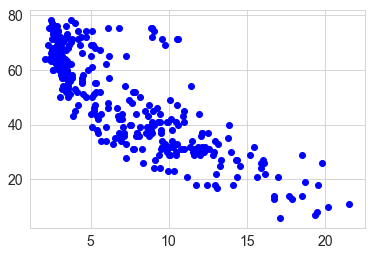

In [60]:
plt.plot(data.Use, data.LowDB1, 'bo')

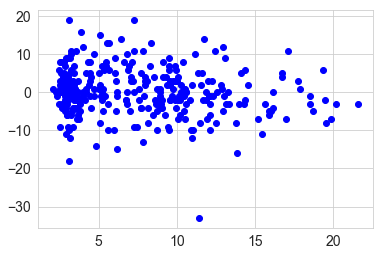

In [61]:
plt.plot(data.Use, data.LowDB1delta, 'bo')

In [67]:
# calculate cluster centroids

# if using hourly data, do we want to aggregate to daily?
aggregate = True

data = readdata[['ID','Dt','Use']]

if granularity =='hourly':
    if aggregate == True:
        #data = readdata[['ID','Dt','Use']]
        #data['Dt'] = data['Dt'].dt.date
        data.loc[:,'Dt'] = data['Dt'].dt.date
        data = data.groupby(['ID','Dt']).sum().reset_index()
        
        weather = pd.read_pickle(location+'daily_weather.pkl.zip')
        
data = pd.merge(data, codebook[['ID','Cluster']], how='inner', on='ID')
data.head()

,ID,Dt,Use,Cluster
0,"(92567555369200, 732213258492)",2017-10-12,1.0,L_H
1,"(92567555369200, 732213258492)",2017-10-13,1.0,L_H
2,"(92567555369200, 732213258492)",2017-10-14,0.0,L_H
3,"(92567555369200, 732213258492)",2017-10-16,3.0,L_H
4,"(92567555369200, 732213258492)",2017-10-17,2.0,L_H


In [69]:
data.groupby('Cluster').var()

,Use
Cluster,
H_H,4075.966829
H_L,430400.820441
H_M,413106.902303
L_H,6.790111
L_L,7.421856
L_M,4.108709
M_H,33.717073
M_L,12.912481
M_M,26.142377
